In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.utils.data import download_file
import scipy.stats as st
import tqdm
import pandas as pd
import os
import matplotlib as mpl
import ligo.skymap.plot
import astropy.units as u
from astropy.coordinates import SkyCoord

%matplotlib notebook

#Defining variables for the data files we need in the project

HECATE_PATH = 'hecate_v1.1_for_GW.csv'
SKYMAP_URL = 'https://dcc.ligo.org/public/0146/G1701985/001/bayestar.fits.gz'
SKYMAP_PATH = 'GW170817_skymap.fits.gz'
save = True

In [2]:
# Cross-matching the galaxies with the GW signal data

candidates = pd.read_csv(HECATE_PATH)
fitsFile = SKYMAP_PATH
[prob, distmu, distsigma, distnorm], header = hp.read_map(fitsFile, field=[0, 1, 2, 3], h = True) # creates 2 arrays, one with 4 columns, and one for the header column that is needed to find an abstract value which is the NSIDE for the ang2pix function
headerDict = {nameKeys:value for nameKeys,value in header} # Creates a dictionnary between a key and a value associated
HECATE_pixelsIndex = hp.ang2pix(headerDict['NSIDE'], candidates['RA'], np.array(candidates['DEC']), lonlat=True) # Converts the 2 angle values we have to pixel values, that we'll then make correspond with the FITS pixels

from gw_tools import apparent_to_L, BNS_merger_rates_M, BNS_merger_rates_MS

In [3]:
# P2D top 5 sources

P2D = prob[HECATE_pixelsIndex] # P2D probability associated to all galaxy of HECATE

sumProb = np.sum(P2D)

P2D_norm = P2D/sumProb # Normalized P2D array

fiveMaxP2DIndex = np.argsort(P2D_norm)[-5:][::-1] # takes the 5 largest elements sorted from largest to smallest ([-5:] is from smallest to largest only)

fiveMaxP2D = P2D_norm[fiveMaxP2DIndex] # fiveMaxProb is the top 5 galaxy candidates that can be the source of the GW

fiveMaxP2DNames = candidates['OBJNAME'][fiveMaxP2DIndex]

fiveMaxP2DNames = fiveMaxP2DNames.to_numpy()

In [4]:
# P3D top 5 sources

# Using eq (1) of Ducoin's paper
P_3d = P2D * distnorm[HECATE_pixelsIndex] * np.exp(-(candidates["D"] - distmu[HECATE_pixelsIndex])**2.0 / (2*distsigma[HECATE_pixelsIndex]**2.0))

P3D_noNan = np.nan_to_num(P_3d)

sumP3D = np.sum(P3D_noNan)

P3D_norm = P3D_noNan/sumP3D # Normalized P3D array

fiveMaxP3DIndex = np.argsort(P3D_norm)[-5:][::-1] 

fiveMaxP3D = P3D_norm[fiveMaxP3DIndex]

fiveMaxP3DNames = candidates['OBJNAME'][fiveMaxP3DIndex]

fiveMaxP3DNames = fiveMaxP3DNames.to_numpy()

In [5]:
# Adding all logSFR_W values of the Wise file to a new SFR_final column of the hecate file

def fill_SFR(old, new):
    return new if not np.isfinite(old) else old

wiseFile = np.genfromtxt('candidates_WISE_SFRs.csv', delimiter = "," , names = True)
SFR_additional = wiseFile['logSFR_W']
SFR_original = candidates['logSFR_HEC'].to_numpy()
SFR_final = SFR_original.copy()

for wise_row in wiseFile:
    target_PGC = wise_row['pgc']
    target_logSFR = wise_row['logSFR_W']
    indexHEC = np.where(candidates['PGC'] == target_PGC)[0][0]

    original_logSFR = candidates['logSFR_HEC'][indexHEC]
    updated_logSFR = fill_SFR(original_logSFR, target_logSFR)
    SFR_final[indexHEC] = updated_logSFR

In [6]:
# Merger rate parameters : Stellar mass 

# constant values from the table 1 of Artale paper at z = 0.1 (redshift very small)

a1 = 1.038
a2 = -6.09

logn_M = a1*candidates['logM_HEC'].to_numpy() + a2 # Column logM_HEC from the csv file to (1) of Artale paper

PnM = P_3d*np.exp(logn_M) # Using formula (1) of the Artale's paper

In [7]:
# P3D*n(M*) top 5 sources

PnM_noNan = np.nan_to_num(PnM)

sumPnM = np.sum(PnM_noNan)

PnM_norm = PnM_noNan/sumPnM # Normalizing

fiveMaxPnMIndex = np.argsort(PnM_norm)[-5:][::-1]

fiveMaxPnM = PnM_norm[fiveMaxPnMIndex]

fiveMaxPnMnames = candidates['OBJNAME'][fiveMaxPnMIndex]

fiveMaxPnMnames = fiveMaxPnMnames.to_numpy()

In [8]:
# Merger rate parameters : Star formation rate (SFR)

# constant values for formula (2)
b1 = 0.8
b2 = 0.323
b3 = -3.555

logn_MSFR = b1*candidates['logM_HEC'].to_numpy() + b2*SFR_final + b3

PnMSFR = P_3d*np.exp(logn_MSFR) # Using formula (2) of the Artale's paper

In [9]:
# P3D*n(M*,SFR) top 5 sources

PnMSFR_noNan = np.nan_to_num(PnMSFR)

sumPnMSFR = np.sum(PnMSFR_noNan)

PnMSFR_norm = PnMSFR_noNan/sumPnMSFR # Normalizing

fiveMaxPnMSFRIndex = np.argsort(PnMSFR_norm)[-5:][::-1]

fiveMaxPnMSFR = PnMSFR_norm[fiveMaxPnMSFRIndex]

fiveMaxPnMSFRnames = candidates['OBJNAME'][fiveMaxPnMSFRIndex]

fiveMaxPnMSFRnames = fiveMaxPnMSFRnames.to_numpy()

In [10]:
# Merger rate parameters : Z (metallicity)

# Creating the array of metallicity from the values we got from the "METAL" column in the HECATE catalogue
Z_sun = 0.0142
logOH_sun = 8.69 # sun oxygen mass fraction
Z = Z_sun*10**(candidates['METAL'].to_numpy()-logOH_sun) # Z/Z_sun(O/H) = (O/H)/(O/H)_sun

# constant values for formula (3)
c1 = 0.701
c2 = 0.356
c3 = 0.411
c4 = -1.968

logn_MSFRZ = c1*candidates['logM_HEC'].to_numpy() + c2*SFR_final + c3*np.log(Z) + c4

P3D_normed = P_3d/np.nansum(P_3d)

PnZ = P3D_normed*np.exp(logn_MSFRZ - np.nanmin(logn_MSFRZ))

In [11]:
# Now we want to make a function that applies the corresponding formula to compute the probability 
# depending on what galaxy data we have available in HECATE

# The 4 arrays we have are P3D, PnM, PnMSFR, PnMSFRZ

# If the value of PnZ is NaN, then replace it by PnMSFR. And do the same from PnZ until P3D 
# as long as it's NaN.
# Note : We take the non-normalized array for the 4 previous probabilities, and we normalize P_final

P_final = np.array(PnZ)

nan_indexes1 = np.isnan(P_final)
P_final[nan_indexes1] = PnMSFR[nan_indexes1]
nan_indexes2 = np.isnan(P_final)
P_final[nan_indexes2] = PnM[nan_indexes2]
nan_indexes3 = np.isnan(P_final)
P_final[nan_indexes3] = P_3d[nan_indexes3]

P_final = np.nan_to_num(P_final)

sumP_final = np.sum(P_final)

P_final = P_final/sumP_final # Normalized PnAll array

In [12]:
# P3D*n(M*,SFR, Z) FINAL FORMULA, top 10 sources

tenMaxP_finalIndex = np.argsort(P_final)[-10:][::-1]

tenMaxP_final = P_final[tenMaxP_finalIndex]

tenMaxP_finalnames = candidates['OBJNAME'][tenMaxP_finalIndex]

tenMaxP_finalnames = tenMaxP_finalnames.to_numpy()

In [13]:
# Results

print("P3D", np.c_[fiveMaxP3DNames, fiveMaxP3D], " "
      , "P3D*n(M*)", np.c_[fiveMaxPnMnames, fiveMaxPnM], " "
      , "P3D*n(M*,SFR)", np.c_[fiveMaxPnMSFRnames, fiveMaxPnMSFR], " "
      , "P3D*n(final)", np.c_[tenMaxP_finalnames, tenMaxP_final],sep='\n')

P3D
[['ESO508-004' 0.09702691660452716]
 ['ESO575-053' 0.08538876969327197]
 ['NGC4993' 0.08403238945297146]
 ['ESO575-055' 0.08214344798589562]
 ['ESO508-024' 0.06778222692654902]]
 
P3D*n(M*)
[['NGC4993' 0.27995863166791]
 ['ESO575-053' 0.1088176694956537]
 ['ESO508-024' 0.1021558875393103]
 ['ESO575-055' 0.08062150453325888]
 ['NGC4968' 0.07418698242706137]]
 
P3D*n(M*,SFR)
[['NGC4993' 0.24999785293107346]
 ['ESO575-053' 0.11501532257306397]
 ['ESO508-024' 0.11194904253350747]
 ['NGC4968' 0.09214261412727676]
 ['ESO575-055' 0.08633991927380752]]
 
P3D*n(final)
[['NGC4993' 0.24760245927580468]
 ['ESO575-053' 0.11391328521266246]
 ['ESO508-024' 0.11087638521643799]
 ['NGC4968' 0.09125973521182779]
 ['ESO575-055' 0.08551263978960363]
 ['ESO508-010' 0.05930557923034813]
 ['PGC797164' 0.05063582605799844]
 ['IC4197' 0.04739423284434588]
 ['PGC169673' 0.03727600767732552]
 ['NGC4830' 0.03536703746176899]]


P2D proba


<IPython.core.display.Javascript object>


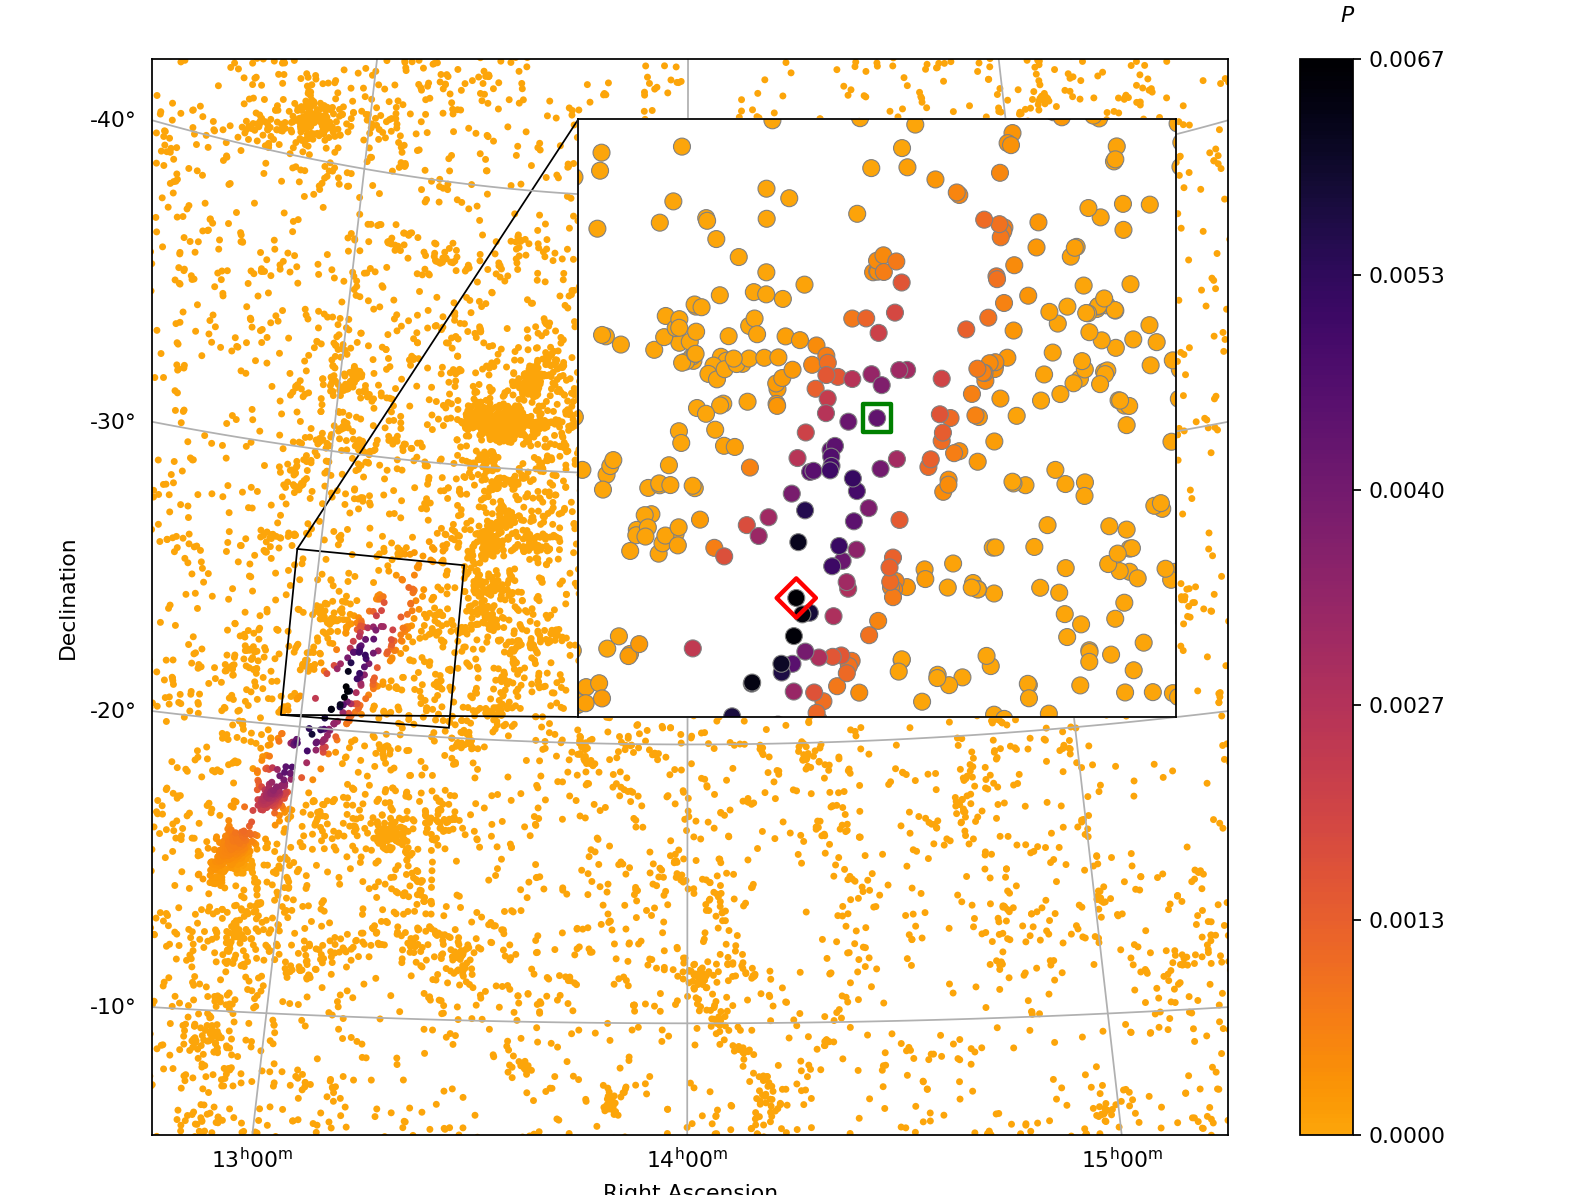

TRUE (ra,dec)=(197.449,-23.3839). BEST (ra,dec)=(196.577,-21.5761)
vmin, vmax = 0.0, 0.006675970091842589

P3D proba


<IPython.core.display.Javascript object>


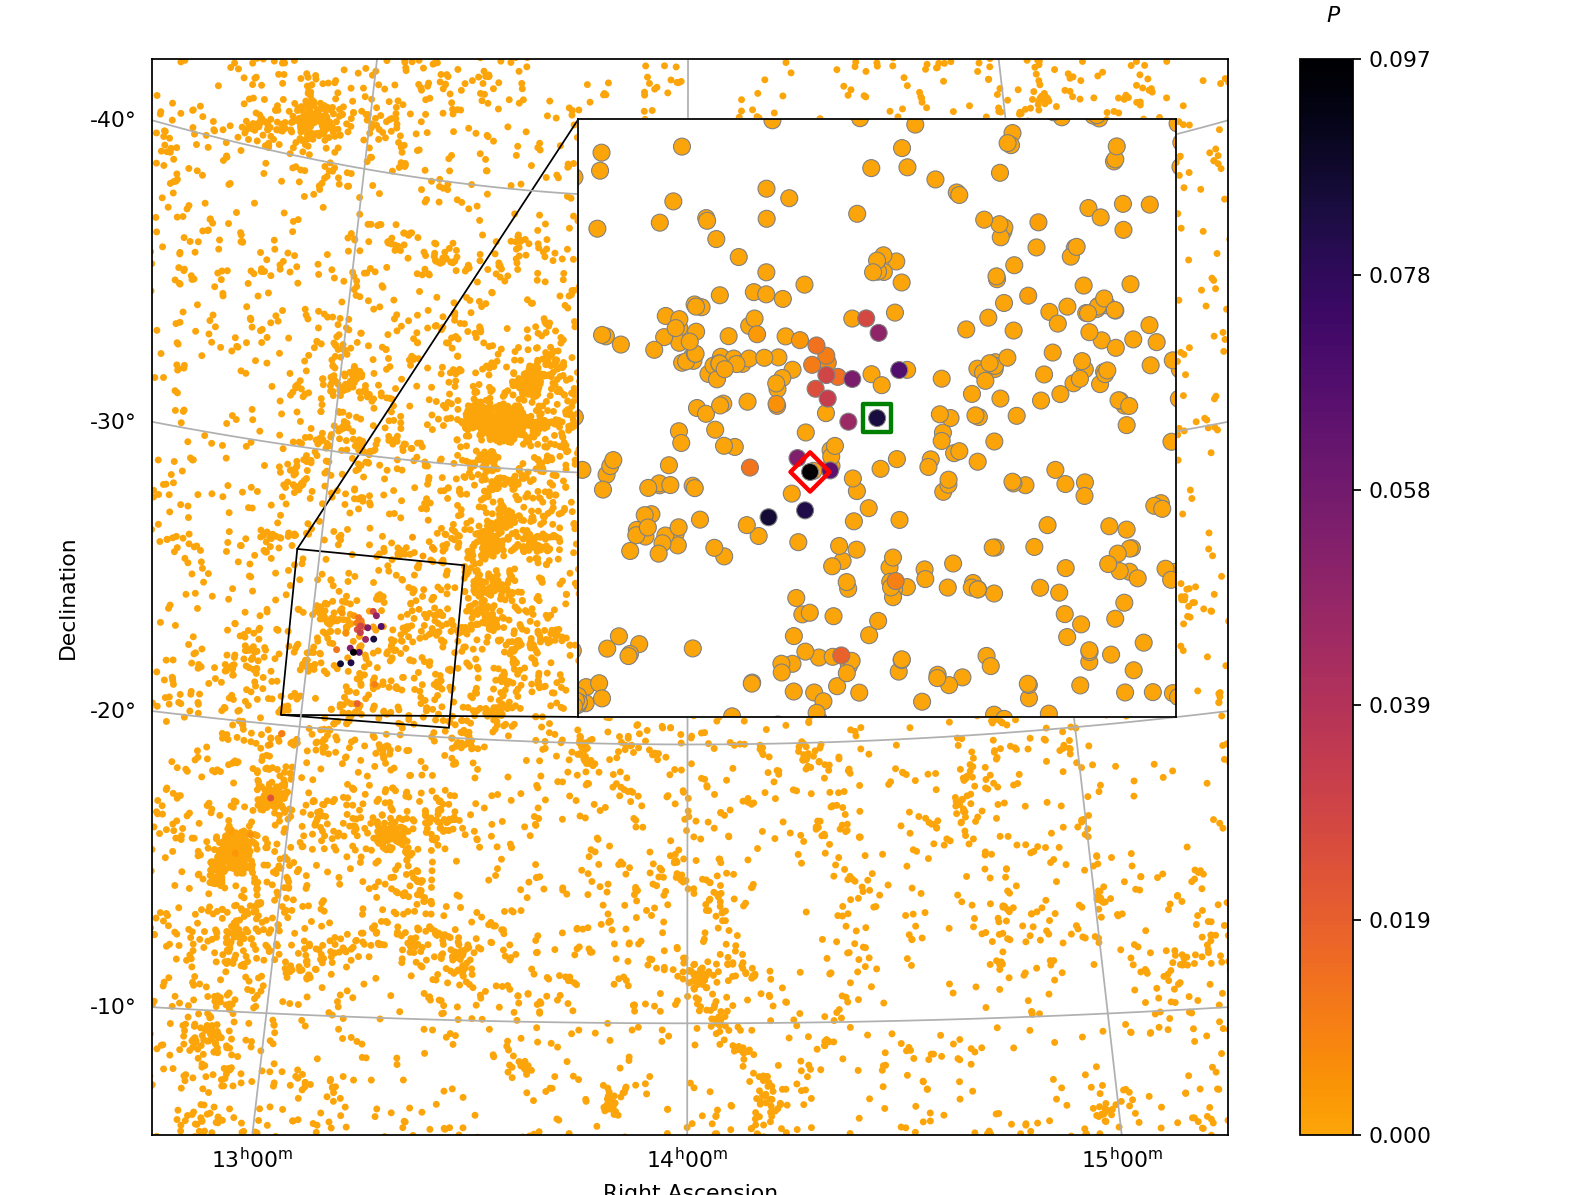

TRUE (ra,dec)=(197.449,-23.3839). BEST (ra,dec)=(196.719,-22.8414)
vmin, vmax = 0.0, 0.09702691660452716

PnM proba


<IPython.core.display.Javascript object>


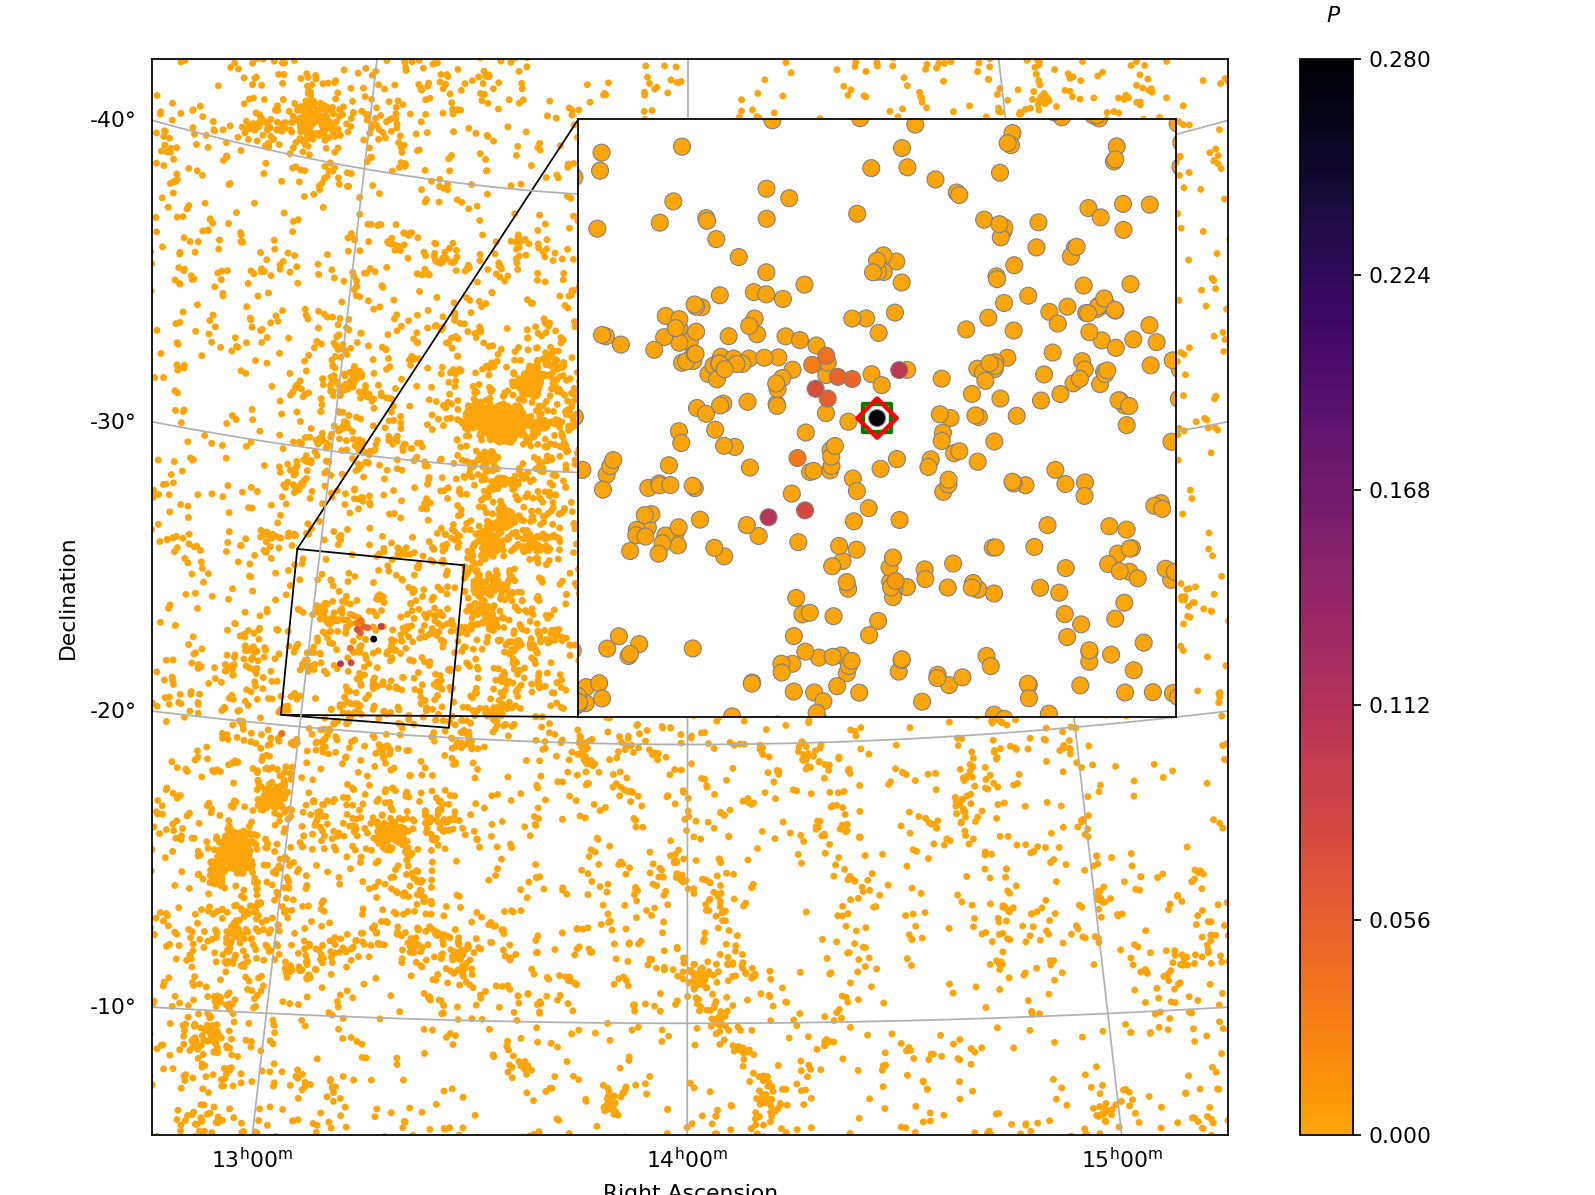

TRUE (ra,dec)=(197.449,-23.3839). BEST (ra,dec)=(197.449,-23.3839)
vmin, vmax = 0.0, 0.27995863166791

PnM*SFR proba


<IPython.core.display.Javascript object>


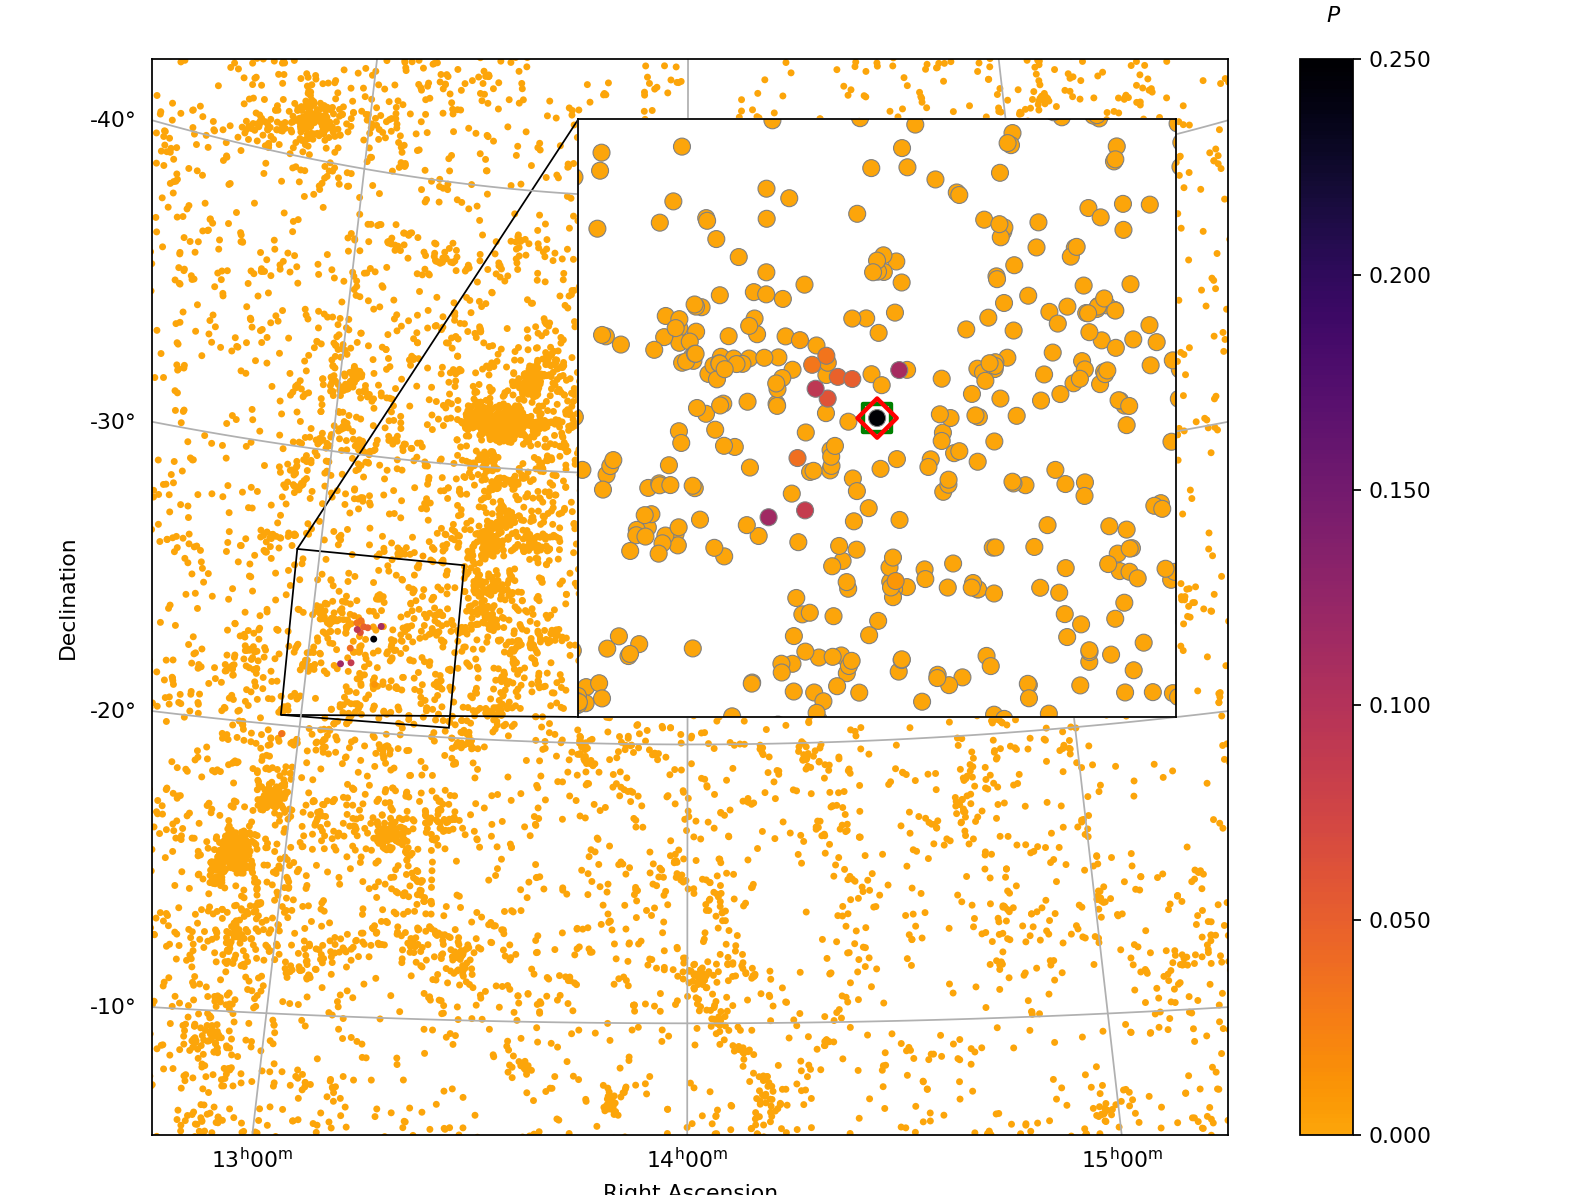

TRUE (ra,dec)=(197.449,-23.3839). BEST (ra,dec)=(197.449,-23.3839)
vmin, vmax = 0.0, 0.24999785293107346

P_final proba


<IPython.core.display.Javascript object>


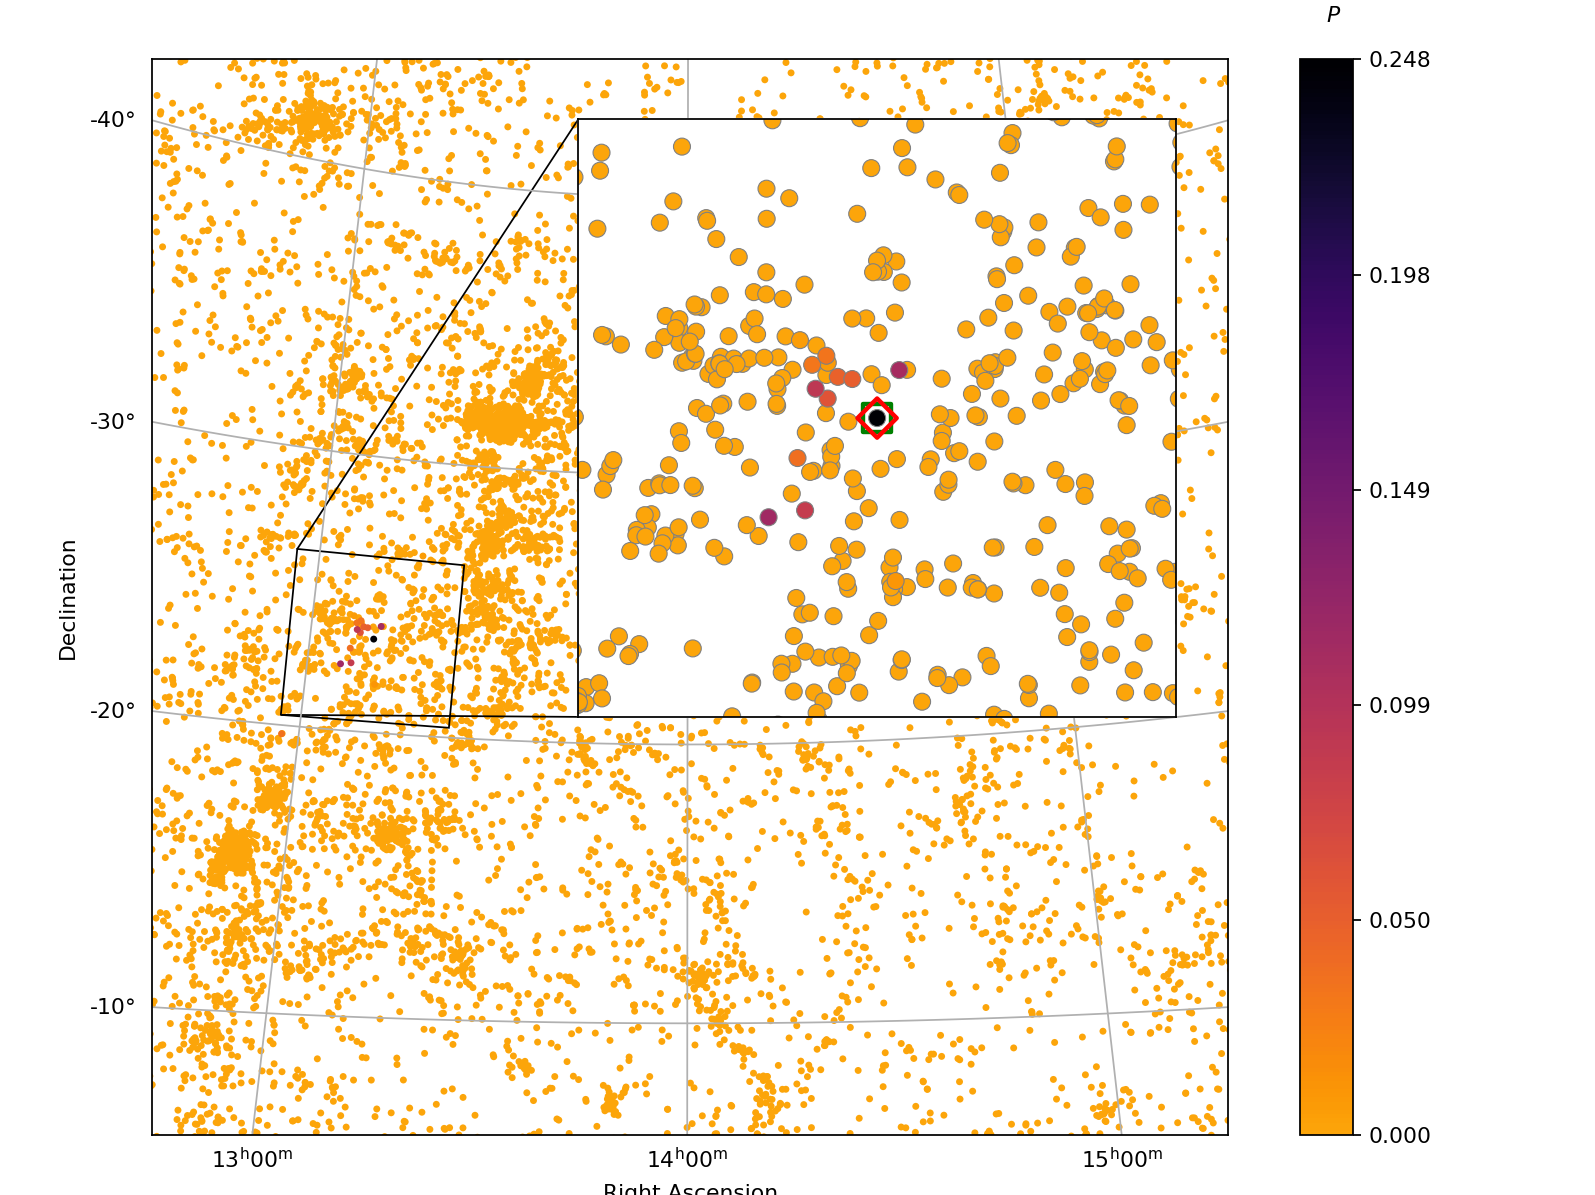

TRUE (ra,dec)=(197.449,-23.3839). BEST (ra,dec)=(197.449,-23.3839)
vmin, vmax = 0.0, 0.24760245927580468


In [14]:
# Plotting for better visualization of the results

true_RA = float(candidates["RA"][candidates["OBJNAME"]=="NGC4993"])
true_DEC = float(candidates["DEC"][candidates["OBJNAME"]=="NGC4993"])

RA = candidates["RA"]
DEC = candidates["DEC"]
mean_RA = np.mean(RA)
mean_DEC = np.mean(DEC)

# We can change these values to center/zoom the figures
radius = 20
inset_radius = 3
rotation = 0
center_offset_ra = 1.8   # in units of radius
center_offset_dec = -1.5   # in units of radius

center=SkyCoord(mean_RA*u.deg, mean_DEC*u.deg)
center_inset = SkyCoord(true_RA*u.deg, true_DEC*u.deg)

def plot_variable(variable, outpath=None, cblabel=True):
    plt.figure()

    ax = plt.axes(
        [0.05, 0.05, 0.9, 0.9],
        projection='astro zoom',
        center=SkyCoord((mean_RA + center_offset_ra*radius)*u.deg, (mean_DEC + center_offset_dec*radius)*u.deg),
        radius=radius*u.deg,
        rotate=rotation*u.deg
    )

    ax_inset = plt.axes(
        [0.3, 0.4, 0.5, 0.5],
        projection='astro zoom',
        center=center_inset,
        radius=inset_radius*u.deg,
        rotate=rotation*u.deg
    )

    for key in ['ra', 'dec']:
        ax_inset.coords[key].set_ticklabel_visible(False)
        ax_inset.coords[key].set_ticks_visible(False)
        ax.coords[key].set_ticks_visible(False)

    ax.mark_inset_axes(ax_inset)
    ax.connect_inset_axes(ax_inset, 'upper left')
    ax.connect_inset_axes(ax_inset, 'lower left')

    cmap = "inferno_r"
    # cmap = "cividis_r"
    cmin = 0.2
    cmax = 1.0
    newcolours = mpl.cm.get_cmap(cmap)(np.linspace(cmin, cmax, 256))
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap
    mycmap = ListedColormap(newcolours)
    cmap = mycmap

    for i, ax_i in enumerate([ax, ax_inset]):
        markersize= 10 if i == 0 else 60
        order = np.argsort(variable)
        which = np.isfinite(variable[order])
        best_RA = candidates["RA"][order[which][-1]]
        best_DEC = candidates["DEC"][order[which][-1]]
        color = variable[order][which]
        #### Konstantinos: where the problem was...
        ax_i.scatter(candidates["RA"][order][which].to_numpy() * u.deg, 
                     candidates["DEC"][order][which].to_numpy() * u.deg, 
                     transform=ax_i.get_transform('world'), 
                     c=color, s=markersize, 
                     cmap=cmap, ec="gray" if i==1 else "none", lw=0.5)
        if i == 1:
            print("TRUE (ra,dec)=({:.6g},{:.6g}). BEST (ra,dec)=({:.6g},{:.6g})".
                  format(true_RA, true_DEC, best_RA, best_DEC))
            ax_i.scatter(true_RA * u.deg, true_DEC * u.deg, c="none", ec="g", marker="s", lw=2, s=160, transform=ax_i.get_transform('world'))
            ax_i.scatter(best_RA * u.deg, best_DEC * u.deg, c="none", ec="r", marker="D", lw=2, s=160, transform=ax_i.get_transform('world'))
    ax.grid()
    # ax.set_ylabel("Right ascension")
    # ax.set_ylabel("Declination")
    vmin, vmax = np.nanmin(variable), np.nanmax(variable)
    vmin = 0.0
    print("vmin, vmax = {}, {}".format(vmin, vmax))
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fmt = '%.{}f'.format(max(3, 1-int(np.floor(np.log10(np.nanmax(variable))))))
    cb = plt.colorbar(sm, ax=ax, ticks=np.linspace(vmin, vmax, 6),
                     format=fmt)
    if cblabel:
        cb.set_label("$P$", labelpad=-45, y=1.05, rotation=0)
    
    ax.set_xlabel("Right Ascension")
    ax.set_ylabel("Declination")

    plt.show()    

print("P2D proba")
plot_variable(P2D_norm, outpath="P_2D.pdf")
plt.savefig('P_2D.pdf', dpi = 300, bbox_inches='tight')
print("", "P3D proba",sep='\n')
plot_variable(P3D_norm, outpath="P_3D.pdf")
plt.savefig('P_3D.pdf', dpi = 300, bbox_inches='tight')
print("", "PnM proba",sep='\n')
plot_variable(PnM_norm, outpath="P_M.pdf")
plt.savefig('P_M.pdf', dpi = 300, bbox_inches='tight')
print("", "PnM*SFR proba",sep='\n')
plot_variable(PnMSFR_norm, outpath="P_MSFR.pdf")
plt.savefig('P_MSFR.pdf', dpi = 300, bbox_inches='tight')
print("", "P_final proba",sep='\n')
plot_variable(P_final, outpath="P_final.pdf")
plt.savefig('P_final.pdf', dpi = 300, bbox_inches='tight')